In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pyro
import pyro.optim
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from typing import Union, Tuple, Optional, Callable, Dict, Set, List
from tqdm import tnrange
from subprocess import Popen
import os
from bb_opt.src.bayesian_opt import (
    normal_priors, normal_variationals,
    spike_slab_priors, SpikeSlabNormal,
    make_bnn_model, make_guide,
    train, bnn_predict, optimize,
    get_model_bnn, acquire_batch_bnn_greedy, train_model_bnn,
    get_model_nn, acquire_batch_nn_greedy, train_model_nn
)
from bb_opt.src.utils import load_fraction_best, plot_performance
from bb_opt.src.hsic import total_hsic, dimwise_mixrq_kernels

# always need to use device 0 in pytorch; if you want to use, e.g., gpu 1 instead,
# make that the only visible GPU and reference it as 0 then

os.environ["CUDA_VISIBLE_DEVICES"] = "6"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
%matplotlib inline

batch_size = 200

labels = np.load('../data/malaria/labels.npy')
inputs = np.load('../data/malaria/inputs.npy')
inputs.shape

(18924, 512)

In [2]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, test_size=.1)

train_inputs = torch.tensor(train_inputs).float().to(device)
train_labels = torch.tensor(train_labels).float().to(device)
train_data = TensorDataset(train_inputs, train_labels)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_inputs = torch.tensor(test_inputs).float().to(device)
test_labels = torch.tensor(test_labels).float().to(device)

In [3]:
n_hidden = 100
non_linearity = 'ReLU'
n_inputs = train_inputs.shape[1]

model = nn.Sequential(
    nn.Linear(n_inputs, n_hidden),
    getattr(nn, non_linearity)(),
    nn.Linear(n_hidden, 1)
).to(device)

# Predictive Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()

In [13]:
for epoch in range(15):
    model.train()
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()

        predictions = model(inputs).squeeze()
        loss = loss_func(predictions, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        predictions = model(test_inputs).squeeze()
        test_loss = loss_func(predictions, test_labels)

    if epoch % 5 == 0:
        print(f'[E{epoch}] Loss = {loss.item():.3f}. Val loss = {test_loss.item():.3f}')

[E0] Loss = 13.919. Val loss = 7.270
[E5] Loss = 10.800. Val loss = 7.089
[E10] Loss = 5.411. Val loss = 6.836


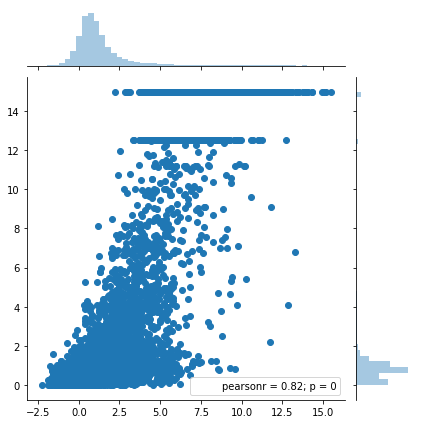

In [14]:
sns.jointplot(model(train_inputs).detach().cpu().squeeze().numpy(), train_labels.cpu().numpy())

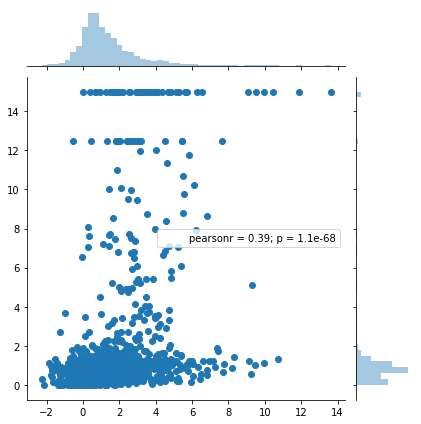

In [15]:
sns.jointplot(predictions.cpu().numpy(), test_labels.cpu().numpy())

In [ ]:
# .99 .4

## Bayesian

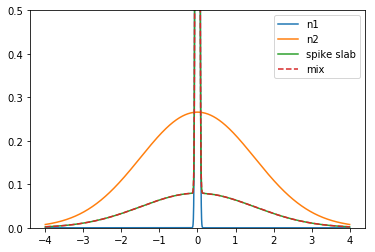

In [4]:
std1 = 0.03
std2 = 1.5
alpha = 0.7

param = torch.tensor(0.)

n1 = pyro.distributions.Normal(0, std1)
n2 = pyro.distributions.Normal(0, std2)
s = SpikeSlabNormal(param, std1, std2, alpha)
x = torch.linspace(-4, 4, 1000)

plt.plot(x.numpy(), n1.log_prob(x).exp().numpy(), label='n1')
plt.plot(x.numpy(), n2.log_prob(x).exp().numpy(), label='n2')
plt.plot(x.numpy(), s.log_prob(x).exp().numpy(), label='spike slab')
plt.plot(x.numpy(),
         (alpha * n1.log_prob(x).exp() + (1 - alpha) * n2.log_prob(x).exp()).numpy(),
         label='mix', ls='dashed')
plt.legend()
plt.ylim(0, 0.5);

In [5]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, test_size=.5)
train_inputs = torch.tensor(train_inputs).float().to(device)
train_labels = torch.tensor(train_labels).float().to(device)
test_inputs = torch.tensor(test_inputs).float().to(device)
test_labels = torch.tensor(test_labels).float().to(device)

In [6]:
n_samples = 10
prior_mean = 0
prior_std = .05

priors = lambda: normal_priors(model, prior_mean, prior_std)
# priors = lambda: spike_slab_priors(model, std2=1.5)
variationals = lambda: normal_variationals(model, prior_mean, prior_std)
bnn_model = make_bnn_model(model, priors, batch_size=batch_size)
guide = make_guide(model, variationals)
# guide = AutoDiagonalNormal(model)

optimizer = pyro.optim.Adam({'lr': 0.01})
pyro.clear_param_store()
svi = pyro.infer.SVI(bnn_model, guide, optimizer, pyro.infer.Trace_ELBO(n_samples))

losses = []

In [7]:
sampled_idx = set([30, 37, 1, 3, 9, 8, 11])
inputs = test_inputs
batch_size = 200

In [22]:
torch.cuda.empty_cache()

In [23]:
n_preds = 500
max_val = 8

batch = []
acquirable_idx = list(set(range(len(inputs))).difference(sampled_idx))
inputs = inputs[acquirable_idx]

with torch.no_grad():
    preds = torch.stack([guide()(inputs).squeeze() for _ in range(n_preds)])

In [29]:
max_input_dist = inputs[preds.argmax(dim=1)]
max_input_dist = max_input_dist.unsqueeze(1)
max_input_dist.shape

torch.Size([500, 1, 512])

In [32]:
X = max_input_dist

In [33]:
sqdists = ((X.unsqueeze(0) - X.unsqueeze(1)) ** 2).unsqueeze(0)
X.shape, sqdists.shape

(torch.Size([500, 1, 512]), torch.Size([1, 500, 500, 1, 512]))

In [34]:
sqdists.sum(dim=-1).shape

torch.Size([1, 500, 500, 1])

In [36]:
dimwise_mixrq_kernels(max_input_dist).shape

torch.Size([500, 500, 1])

In [42]:
torch.tensor([3,6,87,1,2]).sort()[0][-2:]

tensor([ 6, 87])

In [8]:
n_samples = 1000
with torch.no_grad():
    preds = torch.stack([guide()(test_inputs).cpu().squeeze() for _ in range(n_samples)])
preds.shape

torch.Size([1000, 9462])

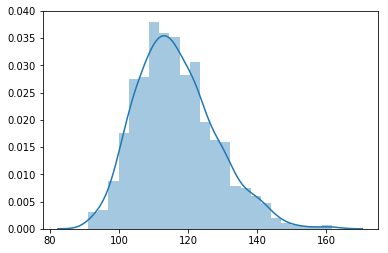

In [33]:
max_dist = preds.max(dim=1)[0]
sns.distplot(max_dist)

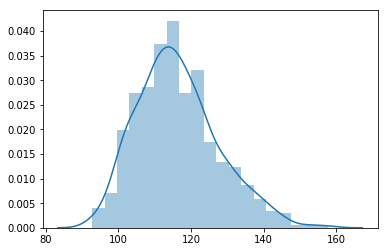

In [34]:
max_dist = preds[:500].max(dim=1)[0]
sns.distplot(max_dist)

In [21]:
from bb_opt.src.hsic import precompute_batch_hsic_stats, compute_point_hsics

In [ ]:
batch_stats = precompute_batch_hsic_stats(max_dist.unsqueeze(1))
hsics = compute_point_hsics(preds, next_points, *batch_stats)

In [7]:
losses += train(svi, 100_000, train_inputs, train_labels, verbose=True)

[S0000] loss: 16,995,970
[S1000] loss: 97,279
[S2000] loss: 50,867
[S3000] loss: 44,398
[S4000] loss: 43,528
[S5000] loss: 39,735
[S6000] loss: 43,772
[S7000] loss: 46,984
[S8000] loss: 43,861
[S9000] loss: 42,981
[S10000] loss: 43,838
[S11000] loss: 44,903


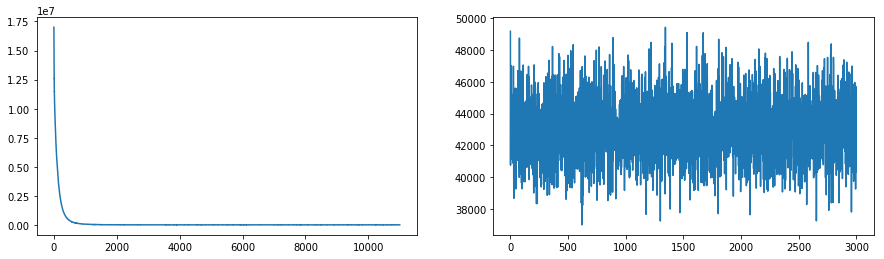

In [8]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.plot(losses)
plt.subplot(122)
plt.plot(losses[-3000:])
# plt.plot(pd.Series(losses[-3000:]).rolling(window=100).median());

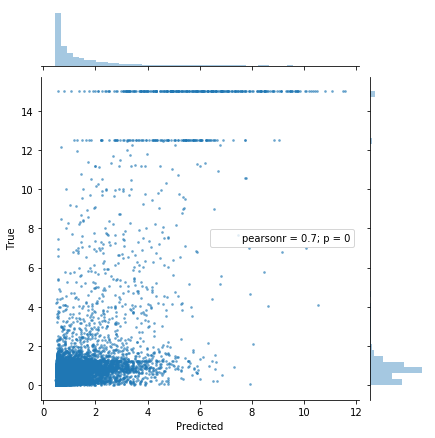

In [9]:
preds = bnn_predict(guide, train_inputs, n_samples=50)
ax = sns.jointplot(preds.mean(axis=0), train_labels.cpu().numpy(), s=3, alpha=0.5)
ax.set_axis_labels('Predicted', 'True');

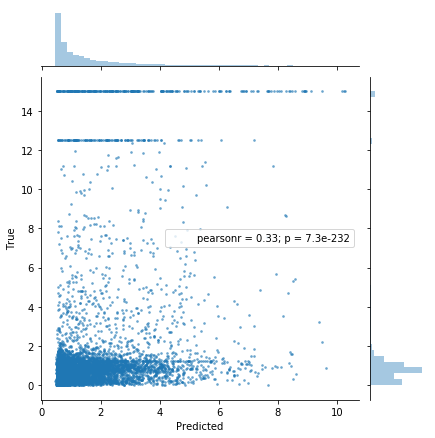

In [10]:
preds = bnn_predict(guide, test_inputs, n_samples=50)
ax = sns.jointplot(preds.mean(axis=0), test_labels.cpu().numpy(), s=3, alpha=0.5)
ax.set_axis_labels('Predicted', 'True');

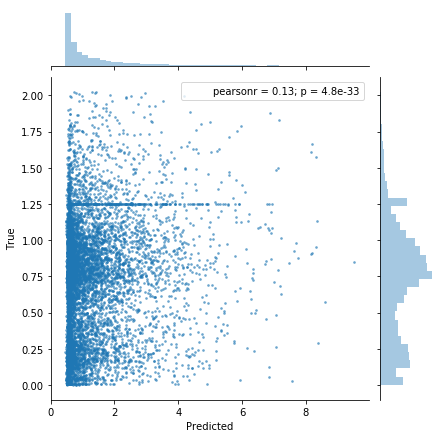

In [20]:
_, sorted_idx = test_labels.sort(descending=True)
n_10_percent = int(len(test_labels) * .1)

preds = bnn_predict(guide, test_inputs[sorted_idx][n_10_percent:], n_samples=50)
ax = sns.jointplot(preds.mean(axis=0), test_labels[sorted_idx][n_10_percent:].cpu().numpy(), s=3, alpha=0.5)
ax.set_axis_labels('Predicted', 'True');

In [ ]:
# .83 .44 (~40K)
# .98 .27 (~30K) w/ spike-slab not converged yet - this one overfits?
# .95 .39 (30K) w/ spike-slab not converged yet - it varies a bit more too?
# .98 .34 (70K) spike-slab converged
# .60 .42 (~13K) w/ early stopping (5 @ 1000)
# .57 .39 (~15K) w/ early stopping (5 @ 1000)
# .67 .36 (????) w/ early stopping (5 @ 1000)
# .70 .33 (~12K) w/ early stopping (5 @ 1000)

### HSIC Acquisition Function
How do the different components of this function look, comparing the best inputs and the rest? How can we tune it to help select the best ones?
  * In practice, any tuning would have to be done on whatever data you already have before you acquire more; ideally this should work without too much data or risk of overfitting...
  * The main thing to tune is `hsic_coeff`, but what should we even compute the HSIC with? What's the initial batch that we're considering adding to?
    * Modify the HSIC acquisition function to let you step through it point by point as you construct the batch and show visualizations like below but including the HSIC of each point with the current batch and the total metric.

In [37]:
percent_best = 1
inputs = test_inputs
labels = test_labels

preds = bnn_predict(guide, inputs, n_samples=250).T
n_best = int(percent_best / 100 * len(preds))

# sort preds by best inputs
sort_idx = labels.sort(descending=True)[1]
preds = preds[sort_idx]

mean = preds.mean(axis=1)
std = preds.std(axis=1)

x_best = list(range(n_best))
x_rest = list(range(n_best, len(mean)))

Text(0.5,1,'Mean / Std')

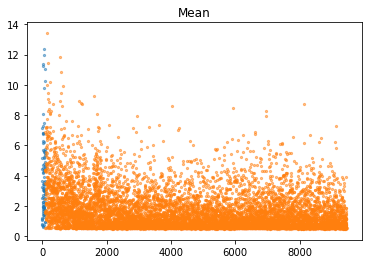

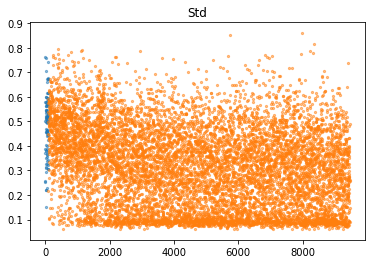

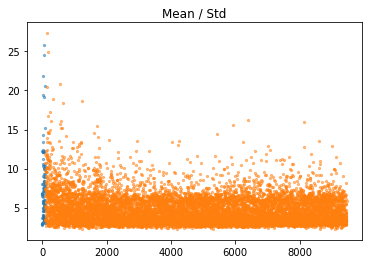

In [38]:
scatter_kwargs = {'s': 5, 'alpha': 0.5}

plt.figure()
plt.scatter(x_best, mean[:n_best], label='Best', **scatter_kwargs)
plt.scatter(x_rest, mean[n_best:], label='Rest', **scatter_kwargs)
plt.title('Mean')

plt.figure()
plt.scatter(x_best, std[:n_best], label='Best', **scatter_kwargs)
plt.scatter(x_rest, std[n_best:], label='Rest', **scatter_kwargs)
plt.title('Std')

plt.figure()
plt.scatter(x_best, mean[:n_best] / std[:n_best], label='Best', **scatter_kwargs)
plt.scatter(x_rest, mean[n_best:] / std[n_best:], label='Rest', **scatter_kwargs)
plt.title('Mean / Std')

# plt.figure()
# plt.scatter(x_best, hsic[:n_best], label='Best', **scatter_kwargs)
# plt.scatter(x_rest, hsic[n_best:], label='Rest', **scatter_kwargs)
# plt.title('HSIC')

In [ ]:
model = bnn_model, guide
inputs = 
sampled_idx = set()
batch_size = 200
n_points_parallel = 100

In [ ]:
hsic_coeff = 5
n_preds = 250
bnn_model, guide = model

with torch.no_grad():
    preds = [torch.unsqueeze(guide()(inputs).squeeze(), 0) for _ in range(n_preds)]
preds = torch.cat(preds)

mean = preds.mean(dim=0)
std = preds.std(dim=0)
metric = mean# / std

acquirable_idx = set(range(len(metric))).difference(sampled_idx)

best_metric = -float('inf')
best_idx = None

for idx in acquirable_idx:
    if metric[idx] > best_metric:
        best_metric = metric[idx]
        best_idx = idx

batch = [best_idx]
acquirable_idx.remove(best_idx)

while len(batch) < batch_size:
    best_idx = None
    best_batch_metric = -float('inf')

    batch_stats = precompute_batch_hsic_stats(preds, batch)

    for next_points in torch.tensor(list(acquirable_idx)).split(n_points_parallel):
        hsics = compute_point_hsics(preds, next_points, *batch_stats)
        idx = hsics.argmax()
        hsic = hsics[idx]
        idx = next_points[idx]

        batch_metric = metric[idx] - hsic_coeff * hsic

        if batch_metric > best_batch_metric:
            best_batch_metric = batch_metric
            best_idx = idx.item()

    batch.append(best_idx)
    acquirable_idx.remove(best_idx)

    if not acquirable_idx:
        break
return batch

# MCMC

In [21]:
from pyro import poutine

In [ ]:
poutine.block()
poutine.condition()

In [23]:
from pyro.infer.mcmc import MCMC, NUTS

In [25]:
kernel = NUTS(bnn_model, adapt_step_size=True)
mcmc = MCMC(kernel, num_samples=1000, warmup_steps=200)

In [29]:
import inspect
print(inspect.getsource(bnn_model))

    def bnn_model(inputs, labels):
        bnn = pyro.random_module("bnn", model, priors())
        nn_sample = bnn()
        nn_sample.train()  # train mode on
        with pyro.iarange("i", len(inputs), subsample_size=batch_size) as i:
            pred = nn_sample(inputs[i]).squeeze()
            pyro.sample(
                "obs",
                pyro.distributions.Normal(pred, torch.ones_like(pred)),
                obs=labels[i].squeeze(),
            )



In [26]:
posterior = mcmc.run(train_inputs, train_labels)

AttributeError: '_Subsample' object has no attribute 'support'

# BO

In [4]:
fraction_best = {}  # {model_name: (mean, std)}
n_repeats = 1
top_k_percent = 1
batch_size = 200

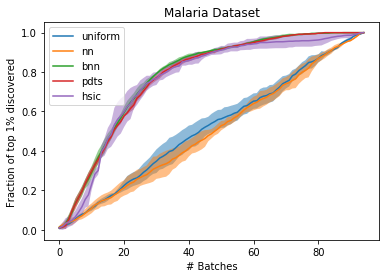

In [6]:
average = True
fraction_best = load_fraction_best(average=average)
plot_performance(fraction_best, averaged=average)

## Greedy NN

In [5]:
n_epochs = 0
mean, std = optimize(get_model_nn, acquire_batch_nn_greedy, train_model_nn, fingerprints,
                     ec50, top_k_percent, n_repeats, batch_size, n_epochs, device)
fraction_best['Greedy NN (Untrained)'] = (mean, std)

n_epochs = 3
mean, std = optimize(get_model_nn, acquire_batch_nn_greedy, train_model_nn, fingerprints,
                     ec50, top_k_percent, n_repeats, batch_size, n_epochs, device)
fraction_best['Greedy NN'] = (mean, std)

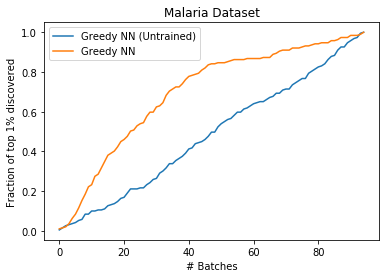

In [6]:
plot_performance(fraction_best)

## Greedy BNN

In [7]:
for _ in range(4):
    Popen('../src/run_bo.py bnn -d 1'.split(' '))

In [ ]:
import pickle
with open('fraction_best.pkl', 'wb') as f:
    pickle.dump(fraction_best, f)

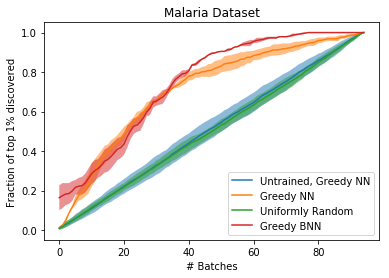

In [59]:
# 200 epochs
plot_performance(fraction_best)

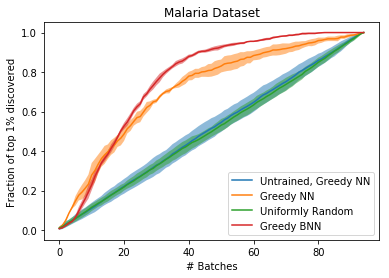

In [23]:
plot_performance(fraction_best)

In [26]:
fraction_best['Greedy BNN'][0][[5, 10, 15, 20, 25]]

array([0.06455026, 0.22962963, 0.38518519, 0.52698413, 0.63915344])

5 -> .ls

10 -> .4
15 -> .5
20 -> .55
25 -> .6

## PDTS

In [43]:
mean, std = optimize(get_model_bnn, acquire_batch_pdts, train_model_bnn,
                     fingerprints, data.ec50, top_k_percent, 2, batch_size, 2, device)
fraction_best['PDTS'] = (mean, std)

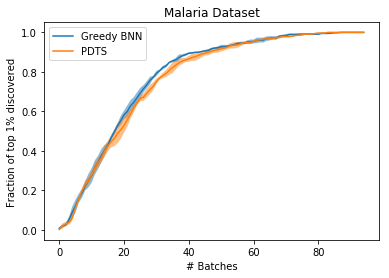

In [36]:
plot_performance(fraction_best)

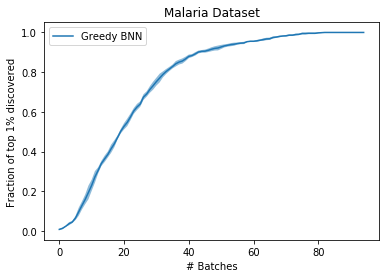

In [33]:
plot_performance(fraction_best)

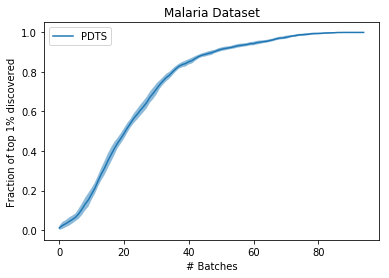

In [22]:
plot_performance(fraction_best)

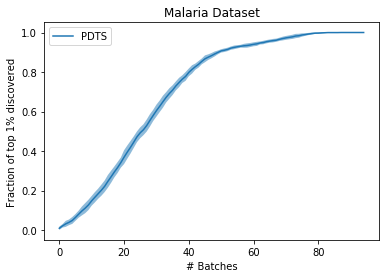

In [20]:
plot_performance(fraction_best)

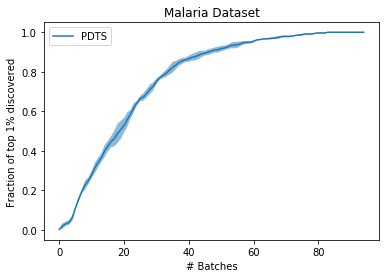

In [19]:
plot_performance(fraction_best)

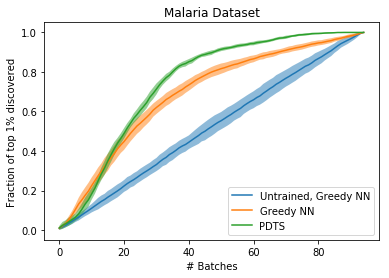

In [24]:
plot_performance(fraction_best)

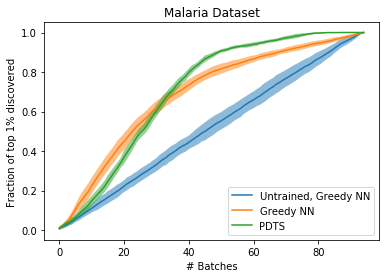

In [22]:
plot_performance(fraction_best)

# Uniform Sampling Baseline

In [ ]:
! ../src/run_bo.py uniform

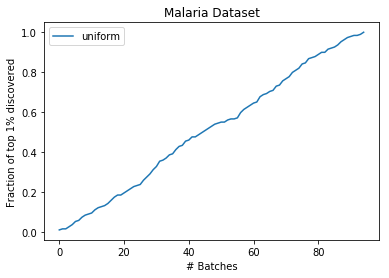

In [70]:
with open("../figures/plot_data/fraction_best_uniform_874939.pkl", "rb") as f:
    fraction_best = pickle.load(f)
plot_performance(fraction_best)

# HSIC

# PBP

In [6]:
from probabilistic_backprop import PBP_net
import numpy as np

In [14]:
np.random.seed(1)
data = np.loadtxt("/cluster/nhunt/github/probabilistic_backprop/data/boston_housing.txt")
x = data[:, :-1]
y = data[:, -1]

In [15]:
# train/test split
idx = np.random.choice(range(len(X)), len(X), replace=False)
n_train = int(len(X) * 0.9)
idx_train = idx[:n_train]
idx_test = idx[n_train:]

x_train = x[idx_train]
y_train = y[idx_train]
x_test = x[idx_test]
y_test = y[idx_test]

# We construct the network with with two-hidden layers
# with 50 neurons in each one and normalizing the training features to have
# zero mean and unit variance in the training set.

n_hidden_units = 50
net = PBP_net(
    x_train, y_train, [n_hidden_units, n_hidden_units], normalize=True, n_epochs=40
)

# We make predictions for the test set

m, v, v_noise = net.predict(X_test)

# We compute the test RMSE

rmse = np.sqrt(np.mean((y_test - m) ** 2))

print(rmse)

# We compute the test log-likelihood

test_ll = np.mean(
    -0.5 * np.log(2 * math.pi * (v + v_noise)) - 0.5 * (y_test - m) ** 2 / (v + v_noise)
)

print(test_ll)

AttributeError: 'Tensor' object has no attribute 'get_value'